# [실습] 다양한 Graph 구조

그동안 배운 요소들을 바탕으로, 이번에는 기존의 Graph 구조를 보다 확장시켜 보겠습니다.   

간단한 Router 구조,

하나의 출발점에서 여러 개로 분리되는 Parallel Calling 이후에 결과를 합치는 Map Reduce 방식,

생성자와 평가자의 구조를 반복하는 Evaluator-Optimizer 방식을 구현해 보겠습니다.



In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninstalled langchain-text-splitters-0.3.5
  Attempting uninstall: langchain
    Fo

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

<ipython-input-2-4e191f275e11>:9: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


## 1. Router
라우터는 State의 값을 참고하여, 목적에 따라 서로 다른 노드로 전달하는 방식을 의미합니다.   
주로 사용자의 입력을 분류하여 서로 다른 작업을 연결하는 의도 분류(Intent Classfication)에서 활용됩니다.

In [ ]:
from typing_extensions import TypedDict, Annotated, Literal, List

from pydantic import BaseModel, Field

from langgraph.graph.message import add_messages

class Recipe(BaseModel):
    name: str = Field(..., description="음식 이름")
    difficulty: str = Field(..., description="만들기의 난이도")
    origin: str = Field(..., description="원산지")
    ingredients: List[str] = Field(..., description="재료 목록")
    instructions: List[str] = Field(..., description="조리법")
    taste: List[str] = Field(..., description="맛에 대한 한 마디의 묘사!")

class Movie(BaseModel):
    name: str = Field(..., description="영화 이름")
    director: str = Field(..., description="감독명")
    actor: List[str] = Field(..., description="주연 배우: 최대 3명까지")
    recommendation: str = Field(..., description="추천하는 이유!")


class State(TypedDict):
    query: str
    classification: str
    recipe: Recipe
    movie:Movie
    advice : Literal['네!', '아니오.']
    # Literal: 범위가 특정 값으로 한정되되는 경우
    answer: str



In [ ]:
from langchain.prompts import ChatPromptTemplate
import random

def recommend_recipe(state):
    prompt = ChatPromptTemplate([
    ('system','당신은 전세계의 이색적인 퓨전 조리법의 전문가입니다.'),
    ('user','''{query}''')
    ])

    recipe_chain = prompt | llm.with_structured_output(Recipe)

    return {'recipe':recipe_chain.invoke(state)}
    # query --> query

def recommend_movie(state):
    prompt = ChatPromptTemplate([
    ('system','당신은 고전 영화의 전문가입니다.'),
    ('user','''{query}''')
    ])

    movie_chain = prompt | llm.with_structured_output(Movie)

    return {'movie':movie_chain.invoke(state)}
    # query --> query


def talk(state):
    return {'answer':llm.invoke(state['query']).content}


def counsel(state):
    if random.random()>=0.5:
        return {'advice':'네!'}
    else:
        return {'advice':'아니오.'}



In [ ]:
def route(state):

    prompt = ChatPromptTemplate(
        [
            ('system', '''당신의 역할은 사용자의 질문에 대답할 사람을 선택하는 것입니다.

1) 음식 관련 질문: 'FOOD'만 출력하세요.
2) 영화 관련 질문: 'MOVIE'만 출력하세요.
3) 고민 상담: 'COUNSEL'만 출력하세요.
4) 그 외의 대화: 'TALK'만 출력하세요.
             '''),
             ('user','User Query: {query}')
        ]
    )
    # Structured_Output으로 만들 수도 있습니다!

    route_chain = prompt | llm

    return {"classification": route_chain.invoke(state).content}
    # query --> query


def route_decision(state):
    # Exact Match 대신 조금 안정적인 조건식

    if "FOOD" in state["classification"]:
        return "recommend_recipe"
    elif "MOVIE" in state["classification"]:
        return "recommend_movie"
    elif "TALK" in state["classification"]:
        return "talk"
    else:
        return "counsel"

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node('recommend_movie', recommend_movie)
builder.add_node('recommend_recipe', recommend_recipe)
builder.add_node('counsel', counsel)
builder.add_node('talk', talk)
builder.add_node('route', route)

builder.add_edge(START, 'route')
builder.add_conditional_edges('route', route_decision,
                              {'recommend_movie':'recommend_movie',
                               'recommend_recipe':'recommend_recipe',
                               'counsel':'counsel',
                               'talk':'talk'})


builder.add_edge('recommend_movie', END)
builder.add_edge('recommend_recipe', END)
builder.add_edge('counsel', END)
builder.add_edge('talk', END)


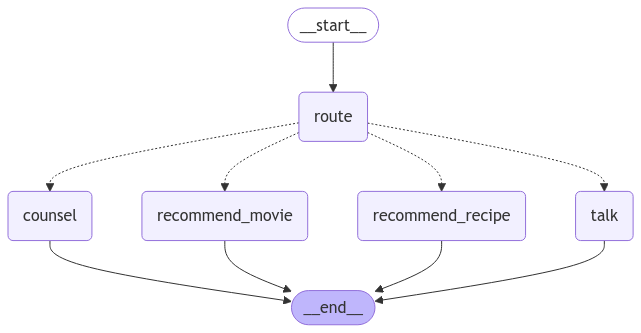

In [ ]:
graph = builder.compile()
graph

In [ ]:
query = '2월에 어울리는 영화 추천해줘.'

result = graph.invoke({'query':query})
result

{'query': '2월에 어울리는 영화 추천해줘.',
 'classification': 'MOVIE',
 'movie': Movie(name='La La Land', director='Damien Chazelle', actor=['Ryan Gosling', 'Emma Stone'], recommendation='2월의 로맨틱한 분위기와 잘 어울리는 뮤지컬 영화입니다. 아름다운 음악과 영상미가 돋보입니다!')}

In [ ]:
query = '연두부로 만들 수 있는 파인 다이닝 있을까?'

result = graph.invoke({'query':query})
result

{'query': '연두부로 만들 수 있는 파인 다이닝 있을까?',
 'classification': 'FOOD',
 'recipe': Recipe(name='연두부 캐비아', difficulty='어려움', origin='한국', ingredients=['연두부', '캐비어', '금가루', '트러플 오일', '폰즈 소스'], instructions=['연두부를 폰즈 소스에 살짝 담가 간을 한다.', '트러플 오일을 살짝 뿌린다.', '캐비아와 금가루를 올려 장식한다'], taste=['고소함', '짭짤함', '고급스러움'])}

In [ ]:
query = 'MoE 구조가 뭐야? 다섯 문장으로 설명해봐.'

result = graph.invoke({'query':query})
result

{'query': 'MoE 구조가 뭐야? 다섯 문장으로 설명해봐.',
 'classification': 'TALK',
 'answer': 'MoE(Mixture of Experts) 구조는 다음과 같이 설명할 수 있습니다:\n\n1.  **전문가 네트워크:** MoE는 여러 개의 독립적인 "전문가" 신경망으로 구성됩니다. 각 전문가는 특정 유형의 입력이나 작업에 특화되어 있습니다.\n2.  **게이트 네트워크:** 입력 데이터는 "게이트 네트워크"를 통과하여 어떤 전문가가 해당 입력을 처리할지 결정합니다. 게이트는 입력에 따라 전문가에게 가중치를 할당합니다.\n3.  **선택적 활성화:** 모든 전문가가 항상 활성화되는 것이 아니라, 게이트 네트워크에서 높은 가중치를 받은 일부 전문가만 활성화되어 입력을 처리합니다.\n4.  **병렬 처리:** 활성화된 전문가들은 입력을 병렬적으로 처리하여 각자의 출력을 생성합니다.\n5.  **결합:** 전문가들의 출력은 게이트 네트워크의 가중치를 사용하여 결합되어 최종 결과를 생성합니다. 이를 통해 MoE는 다양한 전문 지식을 활용하여 더 복잡하고 다양한 작업을 처리할 수 있습니다.'}

## 2. Map-Reduce

위에서는 분류 후에 1번의 LLM을 호출했는데요.   
각자 실행하고 합치는 구조도 만들 수 있습니다.   

대표적인 작업인 리포트 작성 구조를 보겠습니다.   
최초의 LLM이 주제에 대한 섹션을 먼저 구성하고, 섹션별 리포트를 각각의 LLM이 작성하는 방식입니다.

In [ ]:
# 전체 섹션의 구획: Contents (Chapter List)
# Chapter: name, outline


class Chapter(BaseModel):
    name: str = Field(description="챕터의 이름")
    outline: str = Field(description="챕터의 주요 내용, 1문장 길이로")


class Contents(BaseModel):
    contents: List[Chapter] = Field(description="전체 리포트의 섹션 구성")


planner = llm.with_structured_output(Contents)

In [ ]:
example = planner.invoke("LLM의 발전 과정에 대한 보고서 구획을 작성해 주세요.")
example.contents

[Chapter(name='서론', outline='LLM의 정의와 중요성'),
 Chapter(name='초기 LLM 모델', outline='초기 모델의 구조와 한계'),
 Chapter(name='최신 LLM 모델', outline='최신 모델의 발전과정과 성능'),
 Chapter(name='LLM의 활용', outline='LLM의 다양한 활용 분야'),
 Chapter(name='결론', outline='LLM의 미래 발전 방향')]

그래프에서 사용할 State를 정의합니다.   

이번에는 중간 Writer LLM이 사용할 State를 별도로 만들어 보겠습니다.   
이렇게 구성하면 최종 State에서 필요한 부분만 저장할 수 있습니다.

In [ ]:
import operator

# reducer 구조: operator.add
# 단순 + 연산 구조 (리스트의 + 연산이므로로 append)

class State(TypedDict):
    topic: str
    contents: list[Chapter]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str


# 섹션 Writer가 사용할 State
class SubState(TypedDict):
    chapter: Chapter
    completed_sections: Annotated[list, operator.add]



섹션을 생성하는 노드를 구성합니다.

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage


def orchestrator(state: State):

    prompt = ChatPromptTemplate([
        ('system', "주제에 대한 전문가 수준의 깊이 있는 한국어 보고서를 쓰려고 합니다. 보고서의 섹션 구성과, 각 섹션의 간단한 설명을 작성해 주세요."),
        ('user', "주제: {topic}")
    ])
    chain = prompt | planner

    # chain 결과물: Contents (contents: List[Chapter])

    return {"contents": chain.invoke(state).contents}
    # state: topic --> topic
    # Return: List[Chapter]



섹션별 내용을 처리하는 노드를 구성합니다.   
State에는 각각의 Chapter가 아닌 Chapter의 리스트인 Contents가 들어 있는데요.   

`SubState`를 이용해, 각각의 Chapter를 처리하도록 정의하겠습니다.

In [ ]:
def llm_call(state: SubState):
    # SubState :  chapter, complete_sections 2개 property

    chapter = state['chapter']

    prompt = ChatPromptTemplate([
        ('system',"아래 섹션에 대한 상세한 한국어 보고서를 작성하세요." ),
        ('user', "섹션 이름과 주제는 다음과 같습니다: {name} --> {outline}")
    ])

    chain = prompt | llm

    return {"completed_sections": [chain.invoke({'name':chapter.name, 'outline':chapter.outline}).content]}



# 생성된 섹션별 결과들을 결합
def synthesizer(state: State):

    completed_sections = state["completed_sections"]

    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    # join: 전체 리스트 스트링으로 결합하기

    return {"final_report": completed_report_sections}




**가장 중요한 부분입니다😁😁**   
langgraph의 Send()를 이용하면, 리스트의 원소 개수만큼 서브모듈을 호출할 수 있습니다.

In [ ]:
from langgraph.constants import Send

def assign_workers(state: State):
    # Send: 노드를 호출하며, 값을 전달해 준다
    # state['contents']의 개수를 기본적으로 알 수 없는데,
    # 이를 통해 개수만큼 llm_call을 생성하여 호출할 수 있음

    return [Send("llm_call", {"chapter": s}) for s in state["contents"]]

그래프를 구성합니다.

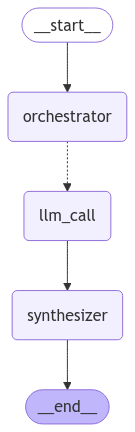

In [ ]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator) # 구획 짜고
builder.add_node("llm_call", llm_call) # 섹션별 글쓰고
builder.add_node("synthesizer", synthesizer) # 합치고


builder.add_edge(START, "orchestrator")

builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
# assign_workers의 결과에 따라 llm_call을 호출

builder.add_edge("llm_call", "synthesizer")
# 생성된 섹션들은 synthesizer로 이동

builder.add_edge("synthesizer", END) # 끝


graph = builder.compile()
graph

In [ ]:
for data in graph.stream({"topic": "GPT 1부터 최신 LLM까지의 발전과정"}, stream_mode='updates'):
    print(data)
    print('--------------')
    # 생성은 병렬적이지만 합치는 순서는 호출한 순서

{'orchestrator': {'contents': [Chapter(name='서론', outline='GPT 모델 발전 과정에 대한 보고서의 목적과 범위 소개'), Chapter(name='GPT-1: 초기 모델의 등장', outline='GPT-1의 구조, 특징, 그리고 당시 성능에 대한 분석'), Chapter(name='GPT-2: 성능 향상과 과제', outline='GPT-2의 개선점, 새로운 기능, 그리고 발생했던 문제점 분석'), Chapter(name='GPT-3: 거대 모델의 가능성', outline='GPT-3의 규모, 성능, 다양한 활용 사례, 사회적 영향 분석'), Chapter(name='GPT-4: 최신 기술 동향', outline='GPT-4의 새로운 기능, 성능 향상, 그리고 윤리적 문제에 대한 논의'), Chapter(name='결론', outline='GPT 모델 발전 과정 요약 및 향후 전망 제시')]}}
--------------
{'llm_call': {'completed_sections': ['## GPT-1: 초기 모델의 등장 - 구조, 특징, 그리고 당시 성능 분석\n\nGPT-1(Generative Pre-trained Transformer 1)은 OpenAI에서 2018년에 발표한 획기적인 언어 모델로, 현대 대규모 언어 모델(LLM) 시대의 막을 연 중요한 모델 중 하나입니다. GPT-1은 사전 학습된 Transformer 아키텍처를 기반으로 텍스트 생성을 통해 다양한 자연어 처리(NLP) 과제에서 뛰어난 성능을 보여주며, 이후 GPT 시리즈 모델 개발의 기반을 마련했습니다. 본 보고서에서는 GPT-1의 구조, 주요 특징, 그리고 당시 성능에 대한 상세한 분석을 제공합니다.\n\n**1. GPT-1의 구조:**\n\nGPT-1은 Transformer 아키텍처의 디코더 부분만을 사용한 12개의 레이어로 구성되어 있습니다. 각 레이어는 다음과 같은 주요 구성 요소로 이루어져 있습니다.\n\n*   **Multi-

In [ ]:
from IPython.display import Markdown
Markdown(data['synthesizer']["final_report"])

## 서론: GPT 모델 발전 과정 보고서 - 목적 및 범위 소개

본 보고서는 OpenAI에서 개발한 GPT (Generative Pre-trained Transformer) 모델의 발전 과정을 체계적으로 분석하고 정리하는 것을 목표로 합니다. GPT 모델은 자연어 처리(NLP) 분야에서 혁신적인 발전을 가져왔으며, 텍스트 생성, 번역, 질의 응답, 요약 등 다양한 응용 분야에서 뛰어난 성능을 보여주고 있습니다. 본 보고서는 GPT 모델의 초기 버전부터 최신 버전까지의 주요 변화와 특징을 심층적으로 살펴보고, 각 모델의 성능 향상에 기여한 핵심 기술과 방법론을 분석합니다.

**보고서의 목적은 다음과 같습니다.**

*   **GPT 모델 발전 단계별 핵심 내용 정리:** GPT-1부터 최신 버전까지 각 모델의 구조, 학습 방법, 데이터셋, 성능 지표 등을 종합적으로 비교 분석합니다.
*   **기술적 진보 분석:** 각 모델의 성능 향상에 기여한 주요 기술적 혁신 (예: 트랜스포머 아키텍처 개선, 스케일링 법칙 적용, 강화 학습 기반 미세 조정 등)을 심층적으로 분석합니다.
*   **응용 분야 및 활용 사례 소개:** GPT 모델이 실제로 활용되고 있는 다양한 응용 분야 (예: 챗봇, 콘텐츠 생성, 검색 엔진, 교육 등)를 소개하고, 각 분야에서의 성공적인 활용 사례를 제시합니다.
*   **한계점 및 윤리적 고려 사항 논의:** GPT 모델의 잠재적인 위험성과 윤리적 문제 (예: 허위 정보 생성, 편향된 결과, 악용 가능성 등)를 분석하고, 이를 해결하기 위한 방안을 모색합니다.
*   **향후 발전 방향 제시:** GPT 모델의 미래 발전 가능성을 예측하고, 연구자들이 주목해야 할 핵심 과제를 제시합니다.

**보고서의 범위는 다음과 같습니다.**

*   **시간적 범위:** GPT-1 (2018)부터 현재까지 발표된 주요 GPT 모델을 포함합니다.
*   **기술적 범위:** 트랜스포머 아키텍처, 자기 지도 학습, 스케일링 법칙, 강화 학습 등 GPT 모델의 핵심 기술을 다룹니다.
*   **응용 분야 범위:** 챗봇, 콘텐츠 생성, 번역, 질의 응답, 요약, 검색 엔진, 교육 등 다양한 응용 분야를 포함합니다.
*   **지리적 범위:** 전 세계적으로 발표된 GPT 모델 관련 연구 자료 및 활용 사례를 분석합니다.

본 보고서는 GPT 모델의 발전 과정을 이해하고, 해당 기술을 효과적으로 활용하고자 하는 연구자, 개발자, 기업 담당자, 정책 결정자 등 다양한 이해관계자들에게 유용한 정보를 제공할 것입니다. 또한, GPT 모델의 잠재력과 한계를 객관적으로 평가하고, 책임감 있는 기술 개발 및 활용을 위한 논의를 촉진하는 데 기여할 것으로 기대됩니다.

---

## GPT-1: 초기 모델의 등장 - 구조, 특징, 그리고 당시 성능 분석

GPT-1(Generative Pre-trained Transformer 1)은 OpenAI에서 2018년에 발표한 획기적인 언어 모델로, 현대 대규모 언어 모델(LLM) 시대의 막을 연 중요한 모델 중 하나입니다. GPT-1은 사전 학습된 Transformer 아키텍처를 기반으로 텍스트 생성을 통해 다양한 자연어 처리(NLP) 과제에서 뛰어난 성능을 보여주며, 이후 GPT 시리즈 모델 개발의 기반을 마련했습니다. 본 보고서에서는 GPT-1의 구조, 주요 특징, 그리고 당시 성능에 대한 상세한 분석을 제공합니다.

**1. GPT-1의 구조:**

GPT-1은 Transformer 아키텍처의 디코더 부분만을 사용한 12개의 레이어로 구성되어 있습니다. 각 레이어는 다음과 같은 주요 구성 요소로 이루어져 있습니다.

*   **Multi-Head Self-Attention:** 입력 텍스트 내의 단어들 간의 관계를 파악하는 데 중요한 역할을 합니다. GPT-1은 12개의 어텐션 헤드를 사용하여 다양한 관점에서 단어 간의 연관성을 학습했습니다. 이를 통해 문맥을 더 잘 이해하고, 문장 내에서 단어의 역할을 정확하게 파악할 수 있었습니다.
*   **Feed-Forward Network (FFN):** 각 단어 벡터를 독립적으로 처리하는 2개의 선형 레이어로 구성되어 있습니다. FFN은 각 단어의 특징을 추출하고 변환하여 모델이 텍스트의 의미를 더 잘 이해하도록 돕습니다.
*   **Layer Normalization:** 각 레이어의 출력을 정규화하여 학습 안정성을 높이고 수렴 속도를 개선합니다.
*   **Residual Connection:** 각 레이어의 입력과 출력을 더하여 그래디언트 소실 문제를 완화하고 더 깊은 네트워크를 학습할 수 있도록 합니다.

GPT-1은 총 1억 1700만 개의 파라미터를 가지고 있으며, 이는 당시 기준으로 상당히 큰 규모였습니다. 이러한 규모는 모델이 복잡한 언어 패턴을 학습하고 일반화하는 데 도움이 되었습니다.

**2. GPT-1의 주요 특징:**

GPT-1은 이전의 언어 모델들과 차별화되는 몇 가지 중요한 특징을 가지고 있습니다.

*   **사전 학습(Pre-training) 및 미세 조정(Fine-tuning):** GPT-1은 레이블이 없는 대규모 텍스트 데이터셋(BooksCorpus)을 사용하여 사전 학습을 진행했습니다. 사전 학습을 통해 모델은 일반적인 언어 지식과 패턴을 학습하고, 이후 특정 NLP 과제에 맞춰 레이블이 있는 데이터셋으로 미세 조정을 수행했습니다. 이러한 접근 방식은 모델이 더 적은 양의 레이블 데이터로도 우수한 성능을 달성할 수 있도록 했습니다.
*   **Transformer 기반 아키텍처:** GPT-1은 Transformer 아키텍처를 사용하여 장거리 의존성을 효과적으로 모델링하고 병렬 처리를 통해 학습 속도를 향상시켰습니다. Transformer 아키텍처는 순환 신경망(RNN) 기반 모델의 한계를 극복하고 더 긴 문맥을 더 잘 이해할 수 있도록 했습니다.
*   **생성 모델(Generative Model):** GPT-1은 주어진 문맥에 따라 텍스트를 생성하는 생성 모델입니다. 이는 모델이 단순히 텍스트를 분류하거나 예측하는 것 이상으로, 새로운 텍스트를 창의적으로 생성할 수 있음을 의미합니다.
*   **제로샷 학습(Zero-shot Learning) 능력:** GPT-1은 특정 과제에 대한 명시적인 학습 없이도 몇 가지 과제에서 어느 정도의 성능을 보였습니다. 이는 모델이 사전 학습을 통해 학습한 일반적인 언어 지식이 새로운 과제에 적용될 수 있음을 시사합니다.

**3. GPT-1의 당시 성능 분석:**

GPT-1은 당시 다양한 NLP 과제에서 뛰어난 성능을 보여주었습니다. 특히, 다음과 같은 과제에서 주목할 만한 결과를 얻었습니다.

*   **자연어 추론(NLI):** GPT-1은 Stanford Natural Language Inference (SNLI) 데이터셋과 Multi-Genre NLI (MNLI) 데이터셋에서 기존 모델들을 능가하는 성능을 보여주었습니다.
*   **질의 응답(QA):** GPT-1은 RACE 데이터셋에서 경쟁력 있는 성능을 달성했습니다.
*   **의미 유사도 판단(Semantic Similarity):** GPT-1은 STS Benchmark에서 우수한 결과를 보였습니다.
*   **텍스트 분류(Text Classification):** GPT-1은 다양한 텍스트 분류 데이터셋에서 기존 모델보다 높은 정확도를 달성했습니다.

하지만 GPT-1은 다음과 같은 몇 가지 한계점도 가지고 있었습니다.

*   **긴 텍스트 생성의 일관성 문제:** GPT-1은 긴 텍스트를 생성할 때 일관성이 떨어지는 경향이 있었습니다. 이는 모델이 장거리 의존성을 완벽하게 모델링하지 못하기 때문일 수 있습니다.
*   **환각(Hallucination):** GPT-1은 사실과 다른 정보를 생성하는 환각 현상을 보였습니다. 이는 모델이 학습 데이터에 존재하는 오류나 편향을 학습했기 때문일 수 있습니다.
*   **계산 비용:** GPT-1은 1억 1700만 개의 파라미터를 가지고 있어 학습 및 추론에 상당한 계산 비용이 필요했습니다.

**결론:**

GPT-1은 사전 학습된 Transformer 아키텍처를 기반으로 텍스트 생성을 통해 다양한 NLP 과제에서 뛰어난 성능을 보여준 혁신적인 언어 모델입니다. GPT-1은 이후 GPT 시리즈 모델 개발의 기반을 마련했으며, 대규모 언어 모델 시대의 시작을 알리는 중요한 모델로 평가받고 있습니다. GPT-1의 성공은 사전 학습 및 미세 조정, Transformer 아키텍처의 강력함, 그리고 생성 모델의 가능성을 입증했습니다. 하지만 GPT-1은 긴 텍스트 생성의 일관성 문제, 환각, 그리고 계산 비용과 같은 몇 가지 한계점도 가지고 있었습니다. 이러한 한계점은 이후 GPT-2, GPT-3, 그리고 GPT-4와 같은 후속 모델에서 개선되었습니다.

---

## GPT-2: 성능 향상과 과제 --> GPT-2의 개선점, 새로운 기능, 그리고 발생했던 문제점 분석

GPT-2는 OpenAI에서 개발한 트랜스포머 기반의 대규모 언어 모델로, 2019년에 발표되어 자연어 처리(NLP) 분야에 큰 영향을 미쳤습니다. GPT-2는 이전 모델인 GPT-1에 비해 모델 크기를 크게 확장하고 더 많은 데이터로 학습하여 텍스트 생성 능력을 획기적으로 향상시켰습니다. 하지만 뛰어난 성능만큼이나 윤리적, 사회적 문제점도 제기되어 공개 당시 논란이 되기도 했습니다. 본 보고서에서는 GPT-2의 구체적인 개선점, 새로운 기능, 그리고 그로 인해 발생했던 문제점을 심층적으로 분석합니다.

**1. GPT-2의 개선점 및 새로운 기능:**

*   **모델 크기 확장:** GPT-2는 GPT-1에 비해 파라미터 수가 크게 증가했습니다. GPT-1의 최대 모델은 1억 1700만 개의 파라미터를 가졌던 반면, GPT-2의 최대 모델은 **15억 개의 파라미터**를 가졌습니다. 이러한 모델 크기 확장은 모델의 학습 능력을 향상시켜 더 복잡하고 다양한 언어 패턴을 학습할 수 있게 했습니다.

*   **데이터셋 확장 및 다양성 증대:** GPT-2는 **WebText**라는 새로운 데이터셋으로 학습되었습니다. WebText는 Reddit에서 추천을 많이 받은 웹페이지에서 수집한 40GB 규모의 텍스트 데이터로 구성되어 있습니다. 이 데이터셋은 다양한 주제와 스타일의 텍스트를 포함하고 있어 GPT-2가 현실 세계의 언어 사용 패턴을 더 잘 학습할 수 있도록 도왔습니다. GPT-1이 책과 같은 비교적 정형화된 데이터를 주로 사용한 것에 비해, GPT-2는 캐주얼한 대화, 뉴스 기사, 블로그 글 등 다양한 형태의 텍스트를 학습하여 더욱 풍부한 언어 표현 능력을 갖추게 되었습니다.

*   **제로샷 학습(Zero-Shot Learning) 능력 향상:** GPT-2의 가장 두드러진 특징 중 하나는 **제로샷 학습** 능력이 크게 향상되었다는 점입니다. 제로샷 학습이란 특정 작업에 대한 명시적인 학습 데이터 없이도 모델이 해당 작업을 수행할 수 있는 능력을 의미합니다. GPT-2는 프롬프트(prompt)라고 불리는 간단한 지시문만으로 번역, 질의응답, 요약 등 다양한 NLP 작업을 수행할 수 있었습니다. 이는 GPT-2가 언어의 일반적인 패턴과 규칙을 매우 잘 학습했기 때문에 가능한 것으로 평가됩니다. 예를 들어, "Translate English to French: The cat sat on the mat."이라는 프롬프트를 입력하면 GPT-2는 별도의 번역 데이터 없이도 "Le chat s'est assis sur le tapis."와 같은 프랑스어 번역 결과를 생성해낼 수 있습니다.

*   **텍스트 생성 능력 향상:** 모델 크기와 데이터셋의 확장을 통해 GPT-2는 텍스트 생성 능력이 크게 향상되었습니다. 이전 모델에 비해 훨씬 더 길고 일관성 있는 텍스트를 생성할 수 있었으며, 생성된 텍스트의 품질 또한 크게 향상되었습니다. GPT-2는 주어진 문맥에 맞춰 자연스럽고 창의적인 텍스트를 생성할 수 있었으며, 때로는 인간이 작성한 텍스트와 구별하기 어려울 정도였습니다.

**2. GPT-2의 문제점 및 과제:**

*   **가짜 뉴스 및 허위 정보 생성 가능성:** GPT-2의 뛰어난 텍스트 생성 능력은 악의적인 목적으로 사용될 가능성이 있다는 우려를 낳았습니다. GPT-2는 가짜 뉴스, 선전, 스팸 메일 등을 매우 설득력 있게 생성할 수 있으며, 이는 사회적 혼란과 오해를 야기할 수 있습니다. 이러한 위험성 때문에 OpenAI는 GPT-2의 전체 모델을 처음에는 공개하지 않고 일부 모델만 공개했습니다.

*   **편향성 문제:** GPT-2는 WebText 데이터셋을 통해 학습되었는데, 이 데이터셋에는 인터넷 상의 다양한 편향성이 내재되어 있습니다. 따라서 GPT-2는 성별, 인종, 종교 등에 대한 편향된 시각을 반영하는 텍스트를 생성할 수 있습니다. 이는 사회적 불평등을 심화시키고 특정 집단에 대한 차별을 조장할 수 있다는 점에서 심각한 문제입니다. 예를 들어, GPT-2는 특정 직업과 성별을 연결하거나 특정 인종 집단에 대한 부정적인 고정관념을 강화하는 텍스트를 생성할 수 있습니다.

*   **악의적인 콘텐츠 생성 가능성:** GPT-2는 혐오 발언, 폭력적인 콘텐츠, 음란물 등 유해한 콘텐츠를 생성할 수 있습니다. 이는 온라인 커뮤니티를 오염시키고 사용자들에게 정신적인 피해를 줄 수 있습니다. 이러한 문제점을 해결하기 위해 OpenAI는 GPT-2의 악의적인 사용을 방지하기 위한 다양한 기술적, 정책적 노력을 기울이고 있습니다.

*   **저작권 문제:** GPT-2는 저작권이 있는 텍스트를 학습 데이터로 사용했기 때문에 생성된 텍스트가 저작권을 침해할 수 있다는 문제가 제기되었습니다. GPT-2가 특정 작가의 스타일을 모방하거나 특정 작품의 내용을 그대로 재현하는 경우, 저작권 침해 논란이 발생할 수 있습니다.

*   **계산 비용 및 접근성 문제:** GPT-2는 매우 큰 모델이기 때문에 학습 및 실행에 많은 계산 자원이 필요합니다. 이는 연구자나 개발자가 GPT-2에 접근하고 활용하는 데 어려움을 줄 수 있습니다. 또한, GPT-2를 상업적으로 사용하기 위해서는 상당한 비용이 소요될 수 있습니다.

**결론:**

GPT-2는 텍스트 생성 능력을 획기적으로 향상시키고 제로샷 학습 능력을 보여주면서 NLP 분야에 큰 영향을 미쳤습니다. 하지만 동시에 가짜 뉴스 생성, 편향성 문제, 악의적인 콘텐츠 생성 가능성 등 심각한 윤리적, 사회적 문제점을 제기했습니다. GPT-2의 개발은 인공지능 기술의 발전과 함께 윤리적인 고려와 안전 장치의 중요성을 강조하는 계기가 되었습니다. 앞으로 GPT-2와 같은 대규모 언어 모델을 개발하고 활용하는 과정에서 이러한 문제점을 해결하기 위한 지속적인 연구와 노력이 필요합니다. 특히, 편향성을 완화하고 악의적인 사용을 방지하기 위한 기술적, 정책적 솔루션 개발이 중요하며, 인공지능 기술의 윤리적 사용에 대한 사회적 논의와 합의가 필요합니다.

---

## GPT-3: 거대 모델의 가능성 - 규모, 성능, 다양한 활용 사례, 사회적 영향 분석

**서론:**

GPT-3(Generative Pre-trained Transformer 3)는 OpenAI에서 개발한 거대 언어 모델로, 이전 모델 대비 압도적인 규모와 향상된 성능을 통해 자연어 처리 분야에 혁신을 가져왔습니다. 이 보고서는 GPT-3의 규모와 성능, 다양한 활용 사례를 분석하고, 그 사회적 영향에 대해 심층적으로 논의합니다. GPT-3의 잠재력과 함께 발생할 수 있는 윤리적, 사회적 문제점을 파악함으로써, 책임감 있는 기술 발전 방향을 제시하는 것을 목표로 합니다.

**1. GPT-3의 규모와 성능:**

GPT-3의 가장 큰 특징은 파라미터 수의 압도적인 규모입니다. 1,750억 개의 파라미터를 보유하고 있으며, 이는 이전 모델인 GPT-2의 100배가 넘는 수치입니다. 이러한 거대한 규모는 모델이 학습할 수 있는 데이터의 양과 복잡성을 증가시켜, 자연어 이해 및 생성 능력의 비약적인 발전을 가능하게 했습니다.

* **규모:** 1,750억 개의 파라미터는 GPT-3가 다양한 텍스트 스타일, 문법 규칙, 그리고 방대한 지식을 학습하고 기억할 수 있도록 합니다.
* **성능:** GPT-3는 다음과 같은 측면에서 뛰어난 성능을 보여줍니다.
    * **자연어 생성:** 인간이 작성한 것과 구별하기 어려울 정도로 자연스러운 텍스트를 생성합니다. 다양한 스타일과 어조를 모방할 수 있으며, 창의적인 글쓰기 또한 가능합니다.
    * **언어 이해:** 문맥을 정확하게 파악하고, 질문에 적절하게 답변하며, 텍스트를 요약하고 번역하는 능력이 뛰어납니다.
    * **Few-shot Learning:** 적은 양의 데이터만으로도 새로운 작업에 적응할 수 있습니다. 이는 모델의 일반화 능력이 뛰어나다는 것을 의미합니다.
    * **Zero-shot Learning:** 별도의 학습 없이도 이전에 경험하지 못한 작업을 수행할 수 있습니다. 이는 모델이 학습한 지식을 다양한 상황에 적용할 수 있다는 것을 보여줍니다.

**2. GPT-3의 다양한 활용 사례:**

GPT-3의 뛰어난 성능은 다양한 분야에서 혁신적인 활용 사례를 만들어내고 있습니다.

* **콘텐츠 생성:**
    * **마케팅 카피 작성:** 광고 문구, 소셜 미디어 게시물, 이메일 캠페인 콘텐츠 등을 자동 생성하여 마케팅 효율성을 높일 수 있습니다.
    * **블로그 포스트 및 기사 작성:** 특정 주제에 대한 정보를 수집하고 정리하여 블로그 포스트나 기사를 자동으로 작성할 수 있습니다.
    * **시나리오 및 소설 작성:** 창의적인 아이디어를 제공하고, 등장인물과 줄거리를 발전시켜 시나리오나 소설 초고를 작성하는 데 도움을 줄 수 있습니다.
* **고객 서비스:**
    * **챗봇 개발:** 고객의 질문에 실시간으로 응답하고, 문제 해결을 지원하는 챗봇을 구축할 수 있습니다. GPT-3 기반 챗봇은 자연스러운 대화 능력을 통해 고객 만족도를 향상시킬 수 있습니다.
    * **가상 비서:** 개인 일정 관리, 이메일 작성, 정보 검색 등 다양한 업무를 지원하는 가상 비서를 구축할 수 있습니다.
* **교육:**
    * **맞춤형 학습 콘텐츠 생성:** 학생의 수준과 학습 스타일에 맞춰 개별화된 학습 콘텐츠를 생성할 수 있습니다.
    * **자동 채점 및 피드백 제공:** 학생의 답안을 자동으로 채점하고, 구체적인 피드백을 제공하여 학습 효과를 높일 수 있습니다.
    * **외국어 학습 지원:** 외국어 작문 연습을 돕고, 문법 오류를 수정하며, 자연스러운 표현을 제시하여 외국어 학습을 효과적으로 지원할 수 있습니다.
* **프로그래밍:**
    * **코드 자동 생성:** 자연어 명령어를 기반으로 코드를 자동으로 생성하여 프로그래밍 생산성을 향상시킬 수 있습니다.
    * **코드 디버깅 지원:** 코드 오류를 자동으로 감지하고, 수정 방안을 제시하여 디버깅 작업을 효율적으로 지원할 수 있습니다.
* **기타:**
    * **번역:** 다양한 언어 간의 번역을 높은 정확도로 수행할 수 있습니다.
    * **요약:** 긴 텍스트를 핵심 내용만 요약하여 제공할 수 있습니다.
    * **질의응답:** 특정 주제에 대한 질문에 대해 정확하고 포괄적인 답변을 제공할 수 있습니다.

**3. GPT-3의 사회적 영향 분석:**

GPT-3는 다양한 분야에서 혁신적인 변화를 가져올 잠재력을 가지고 있지만, 동시에 사회적, 윤리적 문제점을 야기할 수 있습니다.

* **긍정적 영향:**
    * **생산성 향상:** 다양한 업무를 자동화하고 효율성을 높여 생산성을 향상시킬 수 있습니다.
    * **접근성 향상:** 정보 접근성을 높이고, 교육 및 의료 서비스 접근성을 향상시킬 수 있습니다.
    * **창의성 증진:** 새로운 아이디어를 창출하고, 창의적인 활동을 지원하여 창의성을 증진시킬 수 있습니다.
* **부정적 영향:**
    * **일자리 감소:** 자동화로 인해 일부 직업이 사라질 수 있으며, 노동 시장에 변화를 가져올 수 있습니다.
    * **가짜 뉴스 및 허위 정보 확산:** GPT-3는 매우 설득력 있는 가짜 뉴스와 허위 정보를 생성할 수 있으며, 이는 사회적 혼란을 야기할 수 있습니다.
    * **표절 및 저작권 침해:** GPT-3는 기존 콘텐츠를 모방하여 새로운 콘텐츠를 생성할 수 있으며, 이는 표절 및 저작권 침해 문제를 야기할 수 있습니다.
    * **편향성 및 차별 심화:** GPT-3는 학습 데이터에 존재하는 편향성을 그대로 반영할 수 있으며, 이는 특정 집단에 대한 차별을 심화시킬 수 있습니다.
    * **악성 코드 생성:** GPT-3를 이용하여 악성 코드를 생성하고, 사이버 공격에 악용될 수 있습니다.

**4. 결론 및 제언:**

GPT-3는 거대한 규모와 뛰어난 성능을 통해 자연어 처리 분야에 혁신을 가져왔으며, 다양한 분야에서 긍정적인 영향을 미칠 잠재력을 가지고 있습니다. 하지만 일자리 감소, 가짜 뉴스 확산, 편향성 심화 등 부정적인 영향 또한 간과할 수 없습니다.

GPT-3의 잠재력을 최대한 활용하고 부정적인 영향을 최소화하기 위해서는 다음과 같은 노력이 필요합니다.

* **윤리적 가이드라인 개발:** GPT-3와 같은 거대 언어 모델의 개발 및 활용에 대한 윤리적 가이드라인을 개발하여, 책임감 있는 기술 개발을 유도해야 합니다.
* **악용 방지 기술 개발:** 가짜 뉴스 탐지, 표절 방지, 악성 코드 감지 등 GPT-3의 악용을 방지하기 위한 기술 개발에 투자해야 합니다.
* **투명성 확보:** GPT-3를 이용하여 생성된 콘텐츠임을 명확하게 표시하여, 사용자들이 정보를 객관적으로 판단할 수 있도록 투명성을 확보해야 합니다.
* **교육 및 인식 제고:** GPT-3의 작동 원리, 잠재적 위험, 그리고 올바른 활용 방법에 대한 교육 및 인식 제고를 통해 사회 구성원들이 GPT-3를 비판적으로 이해하고 활용할 수 있도록 해야 합니다.
* **규제 마련:** 필요한 경우, GPT-3와 같은 거대 언어 모델의 개발 및 활용에 대한 규제를 마련하여 사회적 위험을 최소화해야 합니다.

GPT-3는 인공지능 기술 발전의 중요한 이정표이지만, 그 잠재력과 위험성을 동시에 고려하여 책임감 있는 기술 개발과 활용이 이루어져야 합니다.  사회 구성원 모두가 GPT-3에 대한 이해도를 높이고, 적극적으로 논의에 참여함으로써, 기술의 혜택을 누리는 동시에 사회적 위험을 최소화하는 방향으로 나아가야 할 것입니다.

---

## GPT-4: 최신 기술 동향 - GPT-4의 새로운 기능, 성능 향상, 그리고 윤리적 문제에 대한 논의

**머리말:** GPT-4는 OpenAI에서 개발한 대규모 언어 모델(LLM)로, 이전 버전인 GPT-3/3.5를 잇는 최첨단 기술입니다. 텍스트 생성, 번역, 요약, 질문 답변 등 다양한 자연어 처리(NLP) 작업을 수행할 수 있으며, 그 성능과 활용 가능성은 이전 모델을 뛰어넘는 수준입니다. 본 보고서는 GPT-4의 주요 기능, 성능 향상, 그리고 그에 따른 윤리적 문제들을 심층적으로 분석하여 GPT-4가 가져올 미래와 그에 대한 대비를 모색합니다.

**1. GPT-4의 새로운 기능 및 성능 향상**

GPT-4는 단순히 텍스트를 생성하는 것을 넘어, 다양한 측면에서 이전 모델 대비 혁신적인 발전을 이루었습니다.

*   **멀티모달 입력 처리:** GPT-4의 가장 큰 특징 중 하나는 텍스트뿐만 아니라 이미지 입력도 처리할 수 있다는 점입니다. 이미지를 분석하고 그 내용을 기반으로 텍스트를 생성하거나, 이미지에 대한 질문에 답변하는 등 복합적인 작업을 수행할 수 있습니다. 이는 교육, 디자인, 의료 등 다양한 분야에서 새로운 활용 가능성을 열어줍니다. 예를 들어, 손으로 그린 스케치를 기반으로 웹사이트 코드를 생성하거나, 의료 이미지를 분석하여 진단을 보조하는 데 활용될 수 있습니다.
*   **향상된 추론 능력:** GPT-4는 이전 모델보다 훨씬 더 복잡하고 추상적인 추론 능력을 갖추었습니다. 문맥을 더 깊이 이해하고, 숨겨진 의미를 파악하며, 논리적인 연결고리를 추론하는 능력이 향상되었습니다. 이는 복잡한 문제 해결, 창의적인 콘텐츠 생성, 그리고 더욱 정확한 정보 검색에 기여합니다.
*   **더욱 자연스럽고 일관성 있는 텍스트 생성:** GPT-4는 텍스트 생성 능력 또한 크게 향상되었습니다. 이전 모델보다 더 자연스럽고 유창하며, 문맥에 맞는 일관성 있는 텍스트를 생성할 수 있습니다. 이는 챗봇, 가상 비서, 콘텐츠 제작 등 다양한 분야에서 사용자 경험을 향상시키는 데 기여합니다. 또한, 특정 스타일이나 어조를 모방하여 텍스트를 생성하는 능력도 향상되어, 더욱 맞춤화된 콘텐츠를 제공할 수 있습니다.
*   **더욱 강력한 코딩 능력:** GPT-4는 코딩 능력 또한 크게 향상되었습니다. 다양한 프로그래밍 언어를 이해하고, 코드를 생성, 디버깅, 최적화하는 능력이 향상되었습니다. 이는 개발자들의 생산성을 높이고, 소프트웨어 개발 과정을 가속화하는 데 기여합니다. 또한, 사용자의 자연어 설명을 기반으로 코드를 생성할 수 있어, 비전문가도 쉽게 소프트웨어를 개발할 수 있도록 지원합니다.
*   **더욱 넓은 범위의 지식 기반:** GPT-4는 이전 모델보다 훨씬 더 넓은 범위의 지식 기반을 가지고 있습니다. 다양한 분야의 정보를 학습하고, 이를 바탕으로 더욱 정확하고 포괄적인 답변을 제공할 수 있습니다. 이는 정보 검색, 교육, 연구 등 다양한 분야에서 활용될 수 있습니다.

**2. GPT-4의 윤리적 문제**

GPT-4의 강력한 기능은 긍정적인 측면뿐만 아니라 윤리적인 문제 또한 제기합니다.

*   **허위 정보 및 가짜 뉴스 생성:** GPT-4는 매우 현실적인 텍스트를 생성할 수 있기 때문에, 허위 정보나 가짜 뉴스를 생성하고 유포하는 데 악용될 위험이 있습니다. 특히, 정치, 사회, 경제 등 민감한 이슈에 대한 허위 정보를 생성하여 사회적 혼란을 야기할 수 있습니다.
*   **편향성 및 차별:** GPT-4는 학습 데이터에 존재하는 편향성을 그대로 반영할 수 있습니다. 이는 특정 집단에 대한 차별적인 발언이나 혐오 표현을 생성하는 것으로 이어질 수 있습니다. 이러한 편향성은 사회적 불평등을 심화시키고, 소외된 집단을 더욱 소외시킬 수 있습니다.
*   **저작권 침해:** GPT-4는 기존 콘텐츠를 학습하여 새로운 콘텐츠를 생성하기 때문에, 저작권 침해 문제가 발생할 수 있습니다. 특히, 특정 작가의 스타일을 모방하거나, 특정 작품의 내용을 그대로 복사하는 경우 저작권 침해 논란이 발생할 수 있습니다.
*   **일자리 감소:** GPT-4는 텍스트 생성, 번역, 코딩 등 다양한 작업을 자동화할 수 있기 때문에, 관련 분야의 일자리가 감소할 수 있다는 우려가 있습니다. 특히, 반복적이고 단순한 업무를 수행하는 직업군에서 일자리 감소가 더욱 심각할 것으로 예상됩니다.
*   **악성 코드 생성 및 사이버 공격:** GPT-4의 코딩 능력은 악성 코드를 생성하거나 사이버 공격을 수행하는 데 악용될 수 있습니다. 특히, 보안 취약점을 악용한 공격 코드를 자동으로 생성하여 사이버 보안을 위협할 수 있습니다.

**3. 윤리적 문제 해결을 위한 노력**

GPT-4의 윤리적 문제 해결을 위해 OpenAI를 비롯한 관련 기관 및 전문가들은 다양한 노력을 기울이고 있습니다.

*   **편향성 완화:** 학습 데이터의 편향성을 완화하기 위해 다양한 데이터 증강 및 필터링 기술을 개발하고 있습니다. 또한, 모델 학습 과정에서 편향성을 탐지하고 수정하는 기술을 개발하여, 편향된 결과물을 생성하는 것을 방지하려고 노력하고 있습니다.
*   **허위 정보 탐지:** GPT-4가 생성한 텍스트의 진위 여부를 판별하는 기술을 개발하고 있습니다. 또한, 사용자들이 허위 정보를 쉽게 식별할 수 있도록 돕는 도구를 개발하여, 허위 정보의 확산을 방지하려고 노력하고 있습니다.
*   **저작권 보호:** 저작권 침해를 방지하기 위해, GPT-4가 생성한 콘텐츠의 출처를 추적하고, 저작권 침해 가능성이 있는 콘텐츠를 필터링하는 기술을 개발하고 있습니다. 또한, 저작권자와 협력하여 저작권 침해 문제를 해결하기 위한 방안을 모색하고 있습니다.
*   **책임 있는 AI 개발:** GPT-4의 개발 및 활용에 대한 윤리적 가이드라인을 제시하고, 책임 있는 AI 개발 문화를 조성하기 위해 노력하고 있습니다. 또한, AI 개발자들에게 윤리적 책임감을 강조하고, AI 윤리 교육을 강화하여, 윤리적인 AI 개발을 장려하고 있습니다.

**4. 결론 및 전망**

GPT-4는 이전 모델을 뛰어넘는 혁신적인 기능을 제공하며, 다양한 분야에서 긍정적인 영향을 미칠 수 있습니다. 하지만 동시에 허위 정보 생성, 편향성, 저작권 침해, 일자리 감소 등 다양한 윤리적 문제 또한 제기합니다.

이러한 문제들을 해결하기 위해서는 기술적인 노력뿐만 아니라 사회적인 논의와 합의가 필요합니다. 정부, 기업, 학계, 시민사회 등 다양한 이해관계자들이 협력하여 GPT-4의 윤리적 문제에 대한 해결책을 모색하고, 책임 있는 AI 개발 및 활용을 위한 규제 체계를 구축해야 합니다.

GPT-4는 아직 초기 단계에 있으며, 앞으로 더욱 발전하고 진화할 것입니다. 우리는 GPT-4가 가져올 미래에 대한 긍정적인 기대와 함께, 그에 따른 윤리적 문제에 대한 경각심을 가지고, 미래 사회에 대한 대비를 해야 합니다. GPT-4를 포함한 AI 기술의 발전은 피할 수 없는 흐름이며, 우리는 이러한 흐름에 적극적으로 참여하고, 미래 사회를 긍정적인 방향으로 이끌어갈 책임이 있습니다.

**향후 연구 방향:**

*   GPT-4의 멀티모달 입력 처리 능력의 활용 사례 연구
*   GPT-4의 편향성을 완화하기 위한 다양한 알고리즘 비교 분석
*   GPT-4가 일자리에 미치는 영향에 대한 심층 분석
*   GPT-4의 윤리적 문제 해결을 위한 정책 제안

이 보고서가 GPT-4에 대한 이해를 높이고, 미래 사회에 대한 대비를 하는 데 도움이 되기를 바랍니다.

---

## 결론: GPT 모델 발전 과정 요약 및 향후 전망 제시

본 보고서에서는 GPT 모델의 발전 과정을 상세히 살펴보고, 현재까지의 성과를 요약하며, 앞으로의 발전 방향과 잠재적 영향을 전망하고자 한다.

**1. GPT 모델 발전 과정 요약:**

GPT (Generative Pre-trained Transformer) 모델은 OpenAI에서 개발한 Transformer 아키텍처 기반의 대규모 언어 모델(LLM)로, 텍스트 생성, 번역, 요약, 질의 응답 등 다양한 자연어 처리(NLP) 과제에서 뛰어난 성능을 보여주고 있다. GPT 모델의 발전 과정은 크게 다음과 같은 단계로 구분할 수 있다.

*   **GPT-1 (2018):** GPT 모델의 첫 번째 버전으로, Transformer 디코더 구조를 사용하여 사전 학습된 언어 모델이다. 지도 학습 없이 대량의 텍스트 데이터를 통해 언어 패턴을 학습하고, fine-tuning을 통해 특정 작업에 적용하는 방식을 제시했다.
*   **GPT-2 (2019):** GPT-1보다 훨씬 큰 규모의 모델로, 다양한 NLP 과제에서 zero-shot learning, 즉 별도의 fine-tuning 없이도 어느 정도 성능을 보이는 능력을 보여주었다. 그러나 모델 규모 증가로 인한 윤리적 문제 (가짜 뉴스 생성 등)가 제기되기도 했다.
*   **GPT-3 (2020):** GPT-2보다 더욱 거대한 규모의 모델로, few-shot learning, 즉 몇 개의 예시만으로도 높은 성능을 달성하는 능력을 보여주었다. 다양한 분야에서 텍스트 생성, 코드 생성, 번역 등 광범위한 활용 가능성을 입증했다.
*   **GPT-3.5 (2022):** GPT-3를 기반으로 강화 학습 (Reinforcement Learning from Human Feedback, RLHF)을 통해 훈련된 모델이다. 인간의 선호도에 맞게 응답을 생성하도록 개선되었으며, ChatGPT와 같은 대화형 AI 서비스의 기반 기술로 활용되었다.
*   **GPT-4 (2023):** GPT-3.5보다 더욱 발전된 모델로, 텍스트뿐만 아니라 이미지 입력도 처리할 수 있는 멀티모달 모델이다. 추론 능력, 창의성, 협업 능력 등이 향상되었으며, 복잡한 문제 해결에 더욱 효과적이다.

각 버전별 발전은 모델 크기 증가, 학습 방법 개선, 그리고 인간 피드백을 활용한 강화 학습 등을 통해 이루어졌으며, 이를 통해 모델의 성능과 활용 가능성이 지속적으로 향상되었다.

**2. 현재까지의 성과 요약:**

GPT 모델은 자연어 처리 분야에 혁신적인 변화를 가져왔으며, 다음과 같은 성과를 달성했다.

*   **높은 텍스트 생성 능력:** 문맥에 맞는 자연스러운 텍스트를 생성하며, 다양한 스타일과 주제를 다룰 수 있다.
*   **뛰어난 번역 및 요약 능력:** 높은 정확도로 텍스트를 번역하고 요약할 수 있다.
*   **코드 생성 능력:** 자연어 설명을 기반으로 코드를 생성할 수 있으며, 프로그래밍 생산성을 향상시킨다.
*   **질의 응답 능력:** 복잡한 질문에 대한 답변을 제공하고, 다양한 정보를 검색하고 종합할 수 있다.
*   **대화형 AI 서비스:** ChatGPT와 같은 대화형 AI 서비스를 통해 사용자에게 편리하고 유용한 정보를 제공한다.

이러한 성과들은 GPT 모델이 다양한 산업 분야에서 활용될 수 있는 가능성을 보여주며, 이미 교육, 의료, 금융, 엔터테인먼트 등 다양한 분야에서 활용되고 있다.

**3. 향후 전망 제시:**

GPT 모델은 앞으로도 지속적인 발전을 거듭할 것으로 예상되며, 다음과 같은 방향으로 발전할 가능성이 높다.

*   **모델 규모 확대 및 효율성 개선:** 모델 규모를 더욱 확대하여 성능을 향상시키는 동시에, 모델 압축 기술 등을 통해 효율성을 높이는 연구가 진행될 것이다.
*   **멀티모달 학습 강화:** 텍스트뿐만 아니라 이미지, 오디오, 비디오 등 다양한 형태의 데이터를 함께 학습하여 더욱 풍부한 정보를 이해하고 처리할 수 있도록 발전할 것이다.
*   **추론 및 문제 해결 능력 향상:** 복잡한 추론 및 문제 해결 능력을 향상시켜 더욱 지능적인 서비스를 제공할 수 있도록 발전할 것이다.
*   **윤리적 문제 해결:** 가짜 뉴스 생성, 편향된 정보 제공 등 윤리적 문제를 해결하기 위한 연구가 더욱 활발하게 진행될 것이다.
*   **특정 분야 전문화:** 특정 분야 (예: 의료, 법률, 금융)에 특화된 GPT 모델이 개발되어 해당 분야의 전문가 수준의 서비스를 제공할 수 있을 것이다.
*   **개인 맞춤형 AI 서비스:** 사용자의 특성과 필요에 맞는 개인 맞춤형 AI 서비스를 제공할 수 있도록 발전할 것이다.

GPT 모델의 발전은 인공지능 기술의 발전을 가속화하고, 우리의 삶과 업무 방식을 혁신적으로 변화시킬 것으로 기대된다. 그러나 동시에 윤리적 문제와 사회적 영향에 대한 심도 있는 논의와 대비가 필요하다. GPT 모델의 발전 과정을 지속적으로 관찰하고, 잠재적 위험을 예측하며, 책임감 있는 개발과 활용을 위한 노력이 중요하다.

## 3. Evaluator-Optimizer 구조

LLM의 최초 출력을 바로 사용해도 되지만, 평가 기준을 두고 반복적으로 검증하게 한다면 그 품질을 높일 수 있습니다.    

주어진 `instruction`에 대한 파이썬 코드를 작성하고, 이를 연속적으로 최적화합니다.

In [ ]:
class State(TypedDict):
    code: str
    instruction: str
    feedback: str
    optimized: str

class Feedback(BaseModel):
    grade: Literal["optimized", "not optimized"] = Field(description="코드가 최적화되었는지 판단합니다.")
    feedback: str = Field(description="코드의 개선이 필요하다면, 어떤 부분을 개선할 수 있을지 설명합니다.")

노드 구조를 구성합니다.   
코드를 생성하는 Generator와, 코드를 비판적으로 평가하는 Optimizer 구조를 구현합니다.

In [ ]:
evaluator = llm.with_structured_output(Feedback)

def code_generator(state: State):
    # 코드를 생성하고, 피드백에 따라 리팩토링합니다.

    if state.get("feedback"):
        # 피드백이 있으면

        result = llm.invoke(
            f"""다음 문제를 해결하는 파이썬 코드를 작성하세요. 설명 없이 코드만 출력하세요.
Instruction:{state['instruction']}
다음의 피드백을 고려하세요.
Feedback: {state['feedback']}""")
    else:
        result = llm.invoke(f"""다음 문제를 해결하는 파이썬 코드를 작성하세요. 설명 없이 코드만 출력하세요.
Instruction:{state['instruction']}""")

    return {"code": result.content}


def code_evaluator(state: State):
    # 실제로는 유닛 테스트를 생성해서 검증하는 것도 필요하겠습니다.

    result = evaluator.invoke(f"""다음의 문제를 해결하는 파이썬 코드가 최적화되었는지 한국어로 평가하세요.
평가 기준은 코드의 길이와 실행 속도 및 메모리 효율성입니다.
코드의 길이가 제일 중요합니다.
---
Instruction:{state['instruction']}
---
Source Code: {state['code']}""")

    return {"optimized": result.grade, "feedback": result.feedback}




# Optimized 값에 따라 경로 설정
def route_code(state: State):
    return 'Accepted' if state["optimized"] == "optimized" else 'Rejected + Feedback'



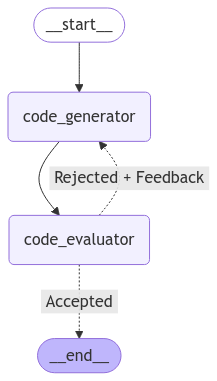

In [ ]:
builder = StateGraph(State)

builder.add_node("code_generator", code_generator)
builder.add_node("code_evaluator", code_evaluator)

builder.add_edge(START, "code_generator")
builder.add_edge("code_generator", "code_evaluator")

builder.add_conditional_edges("code_evaluator",route_code,
                              {"Accepted": END,"Rejected + Feedback": "code_generator"})

graph = builder.compile()
graph

In [ ]:
for data in graph.stream({'instruction':'자연수보다 작은 소수 개수 구하기'}, stream_mode='updates'):
    if 'code_generator' in data:
        print(data['code_generator']['code'])
    else:
        print(data['code_evaluator']['optimized'],'-->', data['code_evaluator']['feedback'])
    print('--------------')

```python
def count_primes_less_than(n):
    if n <= 2:
        return 0
    
    is_prime = [True] * n
    is_prime[0] = is_prime[1] = False
    
    for i in range(2, int(n**0.5) + 1):
        if is_prime[i]:
            for j in range(i*i, n, i):
                is_prime[j] = False
    
    return sum(is_prime)
```
--------------
not optimized --> 제공된 코드는 소수를 찾는 데 효과적인 방법인 에라토스테네스의 체를 사용하고 있습니다. 이 알고리즘은 주어진 숫자보다 작은 모든 소수를 찾는 데 시간 복잡도 O(n log log n)을 가지므로 비교적 효율적입니다. 하지만 코드 길이를 더 줄이기 위해 최적화할 수 있습니다.
--------------
```python
def count_primes(n):
    if n <= 2:
        return 0
    
    primes = [True] * n
    primes[0] = primes[1] = False
    
    for i in range(2, int(n**0.5) + 1):
        if primes[i]:
            for j in range(i*i, n, i):
                primes[j] = False
    
    return sum(primes)
```
--------------
optimized --> 코드의 길이, 실행 속도, 메모리 효율성 모두 적절합니다. 특히 코드 길이가 매우 짧고 간결합니다. 추가적인 최적화는 불필요해 보입니다.
--------------
